In [14]:
import torch

tensor1 = torch.randn((24, 3, 224, 224))
tensor2 = torch.randn((24, 3, 224, 224))

images, flip_images, targets = zip(*tensor1)

In [21]:
torch.vstack((tensor1, tensor2)).shape

torch.Size([48, 3, 224, 224])

In [9]:
images[1].shape

torch.Size([224, 224])

In [10]:
images[2].shape

torch.Size([224, 224])

In [11]:
images[3].shape

torch.Size([224, 224])

In [23]:
torch.cat((tensor1, tensor1)).shape

torch.Size([48, 3, 224, 224])

In [25]:
from transformers import AutoImageProcessor, HieraForPreTraining
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("facebook/hiera-tiny-224-mae-hf")
model = HieraForPreTraining.from_pretrained("facebook/hiera-tiny-224-mae-hf")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
loss = outputs.loss

In [29]:
outputs.logits.shape

torch.Size([1, 196, 768])

In [2]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('convnext_large.fb_in22k_ft_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


In [3]:
model

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=768, out_features=192, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [4]:
model.head.fc

Linear(in_features=1536, out_features=1000, bias=True)

In [5]:
model.head.fc.in_features

1536

In [2]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('coatnet_rmlp_2_rw_384.sw_in12k_ft_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)

In [8]:
model.head

ClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=1024, out_features=1000, bias=True)
  (flatten): Identity()
)

In [9]:
model

MaxxVit(
  (stem): Stem(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm1): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (stages): Sequential(
    (0): MaxxVitStage(
      (blocks): Sequential(
        (0): MbConvBlock(
          (shortcut): Downsample2d(
            (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
            (expand): Identity()
          )
          (pre_norm): BatchNormAct2d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (down): Identity()
          (conv1_1x1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm1): BatchNormAct2d(
            512, eps=1e-05

## Mixup

In [16]:
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch
import numpy as np
import cv2

In [50]:
class AlbumentationsTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 정규화, 텐서 변환
        common_transforms = [
            A.Resize(224, 224),  # 이미지를 224x224 크기로 리사이즈
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
            ToTensorV2()  # albumentations에서 제공하는 PyTorch 텐서 변환
        ]
        self.is_train = is_train

        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 랜덤 밝기 및 대비 조정 추가
            self.transform = A.Compose(
                [
                    A.HorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    A.Rotate(limit=30),  # 최대 15도 회전
                    A.RandomBrightnessContrast(p=0.2),  # 밝기 및 대비 무작위 조정
                ] + common_transforms
            )
            self.basic = A.Compose(common_transforms)
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.basic = A.Compose(common_transforms)

    def __call__(self, image) -> torch.Tensor:
        # 이미지가 NumPy 배열인지 확인
        if not isinstance(image, np.ndarray):
            raise TypeError("Image should be a NumPy array (OpenCV format).")

        # 이미지에 변환 적용 및 결과 반환
        transformed = self.basic(image=image)  # 이미지에 설정된 변환을 적용

        if self.is_train:
            return transformed['image'], self.transform(image=image)['image']

        return transformed['image']  # 변환된 이미지의 텐서를 반환

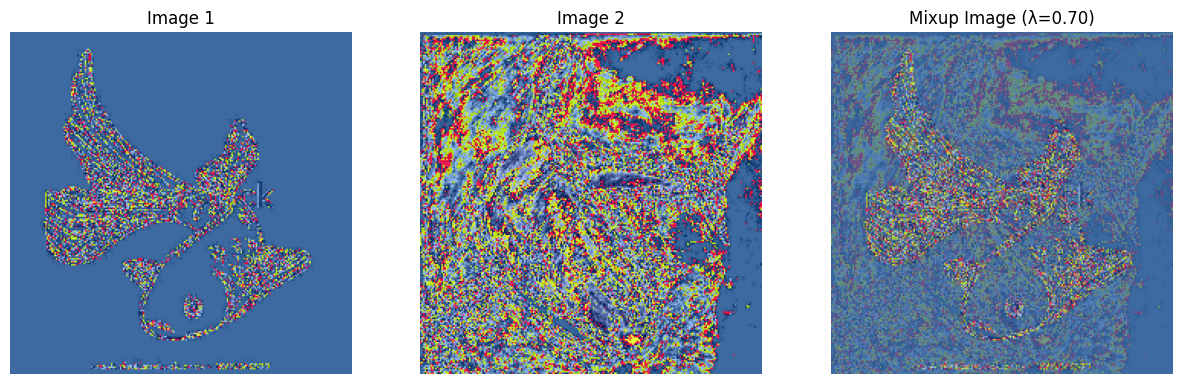

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def tensor_to_image(tensor):
    # 텐서의 크기와 값 범위를 조정 (채널을 마지막으로 이동, [0, 1] -> [0, 255])
    tensor = tensor.permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
    tensor = tensor * 255
    tensor = tensor.byte()  # [0, 255] 범위로 변환
    return Image.fromarray(tensor.numpy())

# 두 이미지를 불러오는 함수
def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR 포맷을 RGB 포맷으로 변환합니다.
    transform = AlbumentationsTransform(is_train=False)
    image = transform(image)
    image = tensor_to_image(image)
    return image

# Mixup을 적용하는 함수
def mixup(image1, image2, alpha=0.5):
    # 이미지를 numpy 배열로 변환
    img1 = np.array(image1)
    img2 = np.array(image2)
    
    # 두 이미지의 크기가 동일한지 확인
    assert img1.shape == img2.shape, "Images must be the same size."
    
    # λ 값을 랜덤하게 [0, 1] 사이에서 생성 (여기서는 alpha를 고정값으로 설정)
    lam = np.random.beta(alpha, alpha)
    lam = 0.7
    
    # Mixup 이미지 생성
    mixed_img = lam * img1 + (1 - lam) * img2
    mixed_img = mixed_img.astype(np.uint8)  # 정수형 변환
    
    return mixed_img, lam

# 이미지를 시각화하는 함수
def plot_images(img1, img2, mixed_img, lam):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img1)
    axes[0].set_title("Image 1")
    axes[0].axis("off")
    
    axes[1].imshow(img2)
    axes[1].set_title("Image 2")
    axes[1].axis("off")
    
    axes[2].imshow(mixed_img)
    axes[2].set_title(f"Mixup Image (λ={lam:.2f})")
    axes[2].axis("off")
    
    plt.show()

# 이미지 파일 경로 설정
image_path1 = "/data/ephemeral/data/train/n01443537/sketch_6.JPEG"
image_path2 = "/data/ephemeral/data/train/n01484850/sketch_21.JPEG"

# 이미지 불러오기
image1 = load_image(image_path1)
image2 = load_image(image_path2)

# Mixup 적용
mixed_image, lam = mixup(image1, image2)

# 시각화
plot_images(image1, image2, mixed_image, lam)


## CutMix

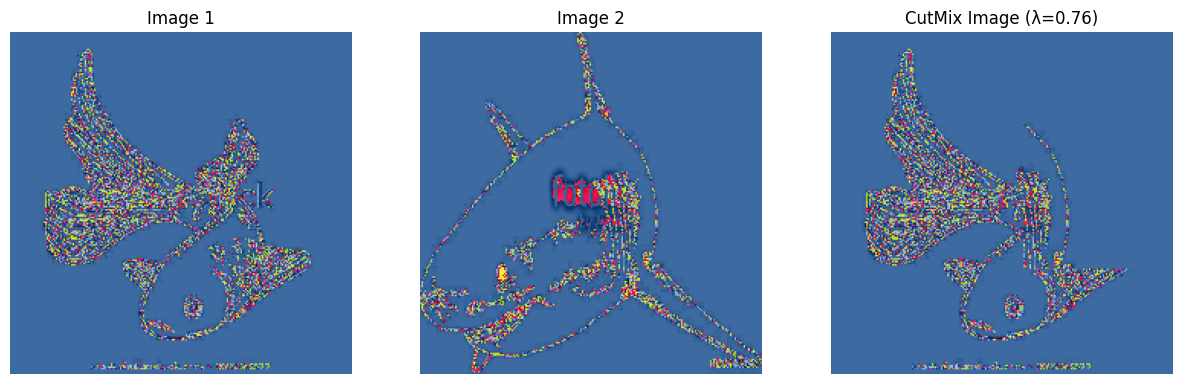

In [49]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Albumentations Transform 정의
class AlbumentationsTransform:
    def __init__(self, is_train=True):
        if is_train:
            self.transform = A.Compose([
                A.Resize(224, 224),
                A.HorizontalFlip(p=0.5),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화,
                ToTensorV2()
            ])
        else:
            self.transform = A.Compose([
                A.Resize(224, 224),
                A.Normalize(),
                ToTensorV2()
            ])

    def __call__(self, image):
        return self.transform(image=image)['image']

# 텐서를 이미지로 변환하는 함수
def tensor_to_image(tensor):
    tensor = tensor.permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
    tensor = tensor * 255
    tensor = tensor.byte()  # [0, 255] 범위로 변환
    return Image.fromarray(tensor.cpu().numpy())

# 이미지를 불러오는 함수
def load_image(path):
    image = Image.open(path).convert("RGB")  # 이미지를 PIL로 불러옴
    image = np.array(image)  # NumPy 배열로 변환
    transform = AlbumentationsTransform(is_train=False)
    image_tensor = transform(image=image)  # Albumentations 적용
    image = tensor_to_image(image_tensor)  # 텐서를 이미지로 변환
    return image_tensor

# CutMix를 적용하는 함수
def cutmix(image1, image2, alpha=1.0):
    # 두 이미지의 크기가 동일해야 함
    assert image1.shape == image2.shape, "Images must be the same size."
    
    # 이미지의 높이와 너비
    H, W = image1.shape[1], image1.shape[2]  # [C, H, W]
    
    # λ 값을 베타 분포로부터 샘플링 (랜덤으로 잘라낼 비율)
    lam = np.random.beta(alpha, alpha)
    lam = 0.7
    
    # 잘라낼 영역의 크기 계산 (Bounding box 좌표)
    cut_rat = np.sqrt(1. - lam)  # 자를 영역의 비율
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    
    # 자를 위치의 중앙점
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    # Bounding box 좌표 계산
    x1 = np.clip(cx - cut_w // 2, 0, W)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    
    # 이미지1에 이미지2의 일부를 붙임
    mixed_image = image1.clone()
    mixed_image[:, y1:y2, x1:x2] = image2[:, y1:y2, x1:x2]
    
    # 새로운 λ 값 (실제 잘린 영역의 비율)
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    
    return mixed_image, lam

# 이미지를 시각화하는 함수
def plot_images(img1, img2, mixed_img, lam):
    # 텐서를 이미지로 변환 (시각화를 위해)
    img1 = tensor_to_image(img1)
    img2 = tensor_to_image(img2)
    mixed_img = tensor_to_image(mixed_img)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img1)
    axes[0].set_title("Image 1")
    axes[0].axis("off")
    
    axes[1].imshow(img2)
    axes[1].set_title("Image 2")
    axes[1].axis("off")
    
    axes[2].imshow(mixed_img)
    axes[2].set_title(f"CutMix Image (λ={lam:.2f})")
    axes[2].axis("off")
    
    plt.show()

# 이미지 파일 경로 설정
image_path1 = "/data/ephemeral/data/train/n01443537/sketch_6.JPEG"
image_path2 = "/data/ephemeral/data/train/n01484850/sketch_10.JPEG"

# 이미지 불러오기
image1 = load_image(image_path1)
image2 = load_image(image_path2)

# CutMix 적용
mixed_image, lam = cutmix(image1, image2)

# 시각화
plot_images(image1, image2, mixed_image, lam)


## CoarseDropout

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


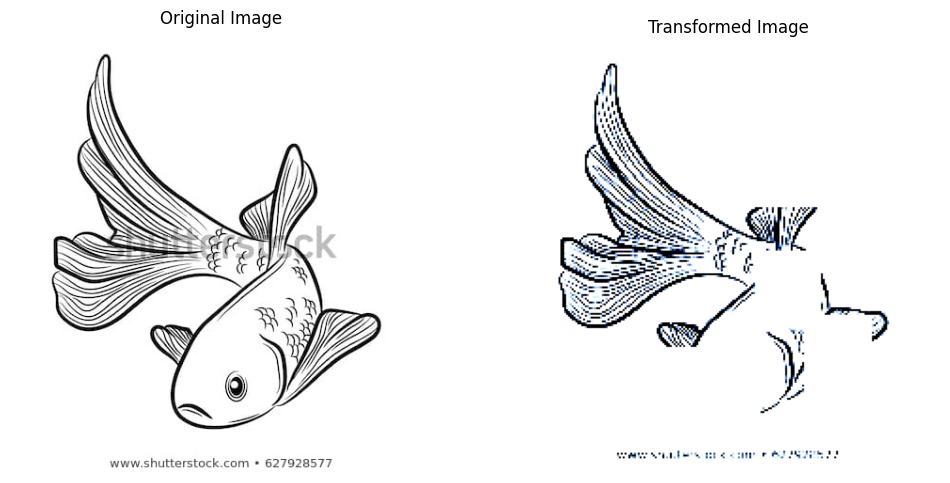

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A

def load_image(path):
    image = Image.open(path).convert("RGB")  # 이미지를 PIL로 불러옴
    image = np.array(image)  # NumPy 배열로 변환
    return image

def apply_transforms(image, transform):
    transformed = transform(image=image)
    return transformed['image']

def plot_images(original_img, transformed_img):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(transformed_img.permute(1, 2, 0).numpy())  # 텐서를 이미지로 변환
    axes[1].set_title("Transformed Image")
    axes[1].axis("off")
    
    plt.show()

# 이미지 파일 경로 설정
image_path = "/data/ephemeral/data/train/n01443537/sketch_6.JPEG"

# 이미지 불러오기
original_image = load_image(image_path)

# 랜덤 마스크 적용
coarse_dropout_transform = A.Compose([
    A.Resize(224, 224),
    A.CoarseDropout(p=1, max_holes=8, min_height=(30), max_height=(50), min_width=30, max_width=50, fill_value=255),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.pytorch.transforms.ToTensorV2()
])

transformed_image = apply_transforms(original_image, coarse_dropout_transform)

# 시각화
plot_images(original_image, transformed_image)


In [87]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('eva02_large_patch14_448.mim_m38m_ft_in22k_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [88]:
model

Eva(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (rope): RotaryEmbeddingCat()
  (blocks): ModuleList(
    (0-23): 24 x EvaBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): EvaAttention(
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLU(
        (fc1_g): Linear(in_features=1024, out_features=2730, bias=True)
        (fc1_x): Linear(in

In [89]:
model.head

Linear(in_features=1024, out_features=1000, bias=True)

In [1]:
from PIL import Image
import requests
import torch

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/iss

In [6]:
output = model.vision_model(inputs['pixel_values'])

In [8]:
output['last_hidden_state'].shape

torch.Size([1, 50, 768])

In [9]:
output['pooler_output'].shape

torch.Size([1, 768])

In [1]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'swinv2_cr_tiny_ns_224.sw_in1k',
    pretrained=True,
    features_only=True,
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

for o in output:
    # print shape of each feature map in output
    # e.g. for swin_base_patch4_window7_224 (NHWC output)
    #  torch.Size([1, 56, 56, 128])
    #  torch.Size([1, 28, 28, 256])
    #  torch.Size([1, 14, 14, 512])
    #  torch.Size([1, 7, 7, 1024])
    # e.g. for swinv2_cr_small_ns_224 (NCHW output)
    #  torch.Size([1, 96, 56, 56]) 
    #  torch.Size([1, 192, 28, 28])
    #  torch.Size([1, 384, 14, 14])
    #  torch.Size([1, 768, 7, 7])
    print(o.shape)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 96, 56, 56])
torch.Size([1, 192, 28, 28])
torch.Size([1, 384, 14, 14])
torch.Size([1, 768, 7, 7])


In [1]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('swinv2_cr_tiny_ns_224.sw_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model

SwinTransformerV2Cr(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): SwinTransformerV2CrStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerV2CrBlock(
          (attn): WindowMultiHeadAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (meta_mlp): Mlp(
              (fc1): Linear(in_features=2, out_features=384, bias=True)
              (act): ReLU()
              (drop1): Dropout(p=0.125, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=3, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
          )

In [5]:
model.head.fc

Linear(in_features=768, out_features=1000, bias=True)

In [27]:
from transformers import AutoImageProcessor, ConvNextV2ForImageClassification
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

preprocessor = AutoImageProcessor.from_pretrained("facebook/convnextv2-base-22k-384")
model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-base-22k-384")

inputs = preprocessor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label]),


remote control, remote


(None,)

In [28]:
model

ConvNextV2ForImageClassification(
  (convnextv2): ConvNextV2Model(
    (embeddings): ConvNextV2Embeddings(
      (patch_embeddings): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextV2LayerNorm()
    )
    (encoder): ConvNextV2Encoder(
      (stages): ModuleList(
        (0): ConvNextV2Stage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextV2Layer(
              (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
              (layernorm): ConvNextV2LayerNorm()
              (pwconv1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELUActivation()
              (grn): ConvNextV2GRN()
              (pwconv2): Linear(in_features=512, out_features=128, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextV2Layer(
              (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=

In [26]:
import torch.nn as nn
model.classifier = nn.Identity()

outputs = model(**inputs, output_hidden_states=True)
print(outputs.logits)
features = outputs.hidden_states[-1][:, 0, :]
features

tensor([[ 1.0425,  0.9864,  2.0039,  ...,  0.3907,  0.9275, -0.0822]],
       grad_fn=<NativeLayerNormBackward0>)


tensor([[[ 1.8430e+00,  2.9226e+00,  2.6020e+00,  5.2655e-01, -1.1117e+00,
           6.4327e-01,  2.0767e+00,  1.9117e+00,  1.0943e+00,  4.4747e+00,
           1.0360e+00,  1.5774e+00],
         [ 3.5205e+00,  9.6536e+00,  7.9915e+00,  5.7673e+00,  6.1896e-01,
          -3.1499e+00,  5.5567e+00,  5.9890e+00,  1.6786e+00,  2.1293e+00,
           1.2945e-01,  3.3583e+00],
         [ 1.1507e+01,  1.5422e+01,  1.3734e+01,  4.5417e+00,  3.9146e+00,
           4.6084e+00,  8.8869e+00,  5.0963e+00,  2.8320e+00,  6.3593e-01,
          -1.1974e-01,  2.2327e+00],
         [ 2.3898e+00,  6.0178e+00,  2.8817e+00, -5.5766e-03, -3.8640e-01,
          -1.1586e+00,  9.8481e-01,  8.9974e-01,  1.6089e+00,  3.9632e-01,
           3.5388e-02,  1.6255e+00],
         [ 1.2496e+00,  5.4423e-01,  3.9793e-01, -9.0350e-01, -2.7769e+00,
          -2.6370e+00,  2.7183e+00, -2.5002e-01,  1.2285e+00,  8.8919e-02,
           8.4322e-01,  3.2940e+00],
         [ 6.8962e-02,  1.4324e+00,  7.5532e-01, -9.6740e-01, -5.

In [10]:
model.classifier.in_features

1024

In [29]:
from transformers import AutoModelForImageClassification 
model = AutoModelForImageClassification.from_pretrained("team-lucid/swinv2-base-path4-window24-384-doc")

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at team-lucid/swinv2-base-path4-window24-384-doc and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
model

Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=4, bias=False)
                  )
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_featur

In [31]:
import torch.nn as nn
model.classifier = nn.Identity()

In [32]:
model(**inputs)

Swinv2ImageClassifierOutput(loss=None, logits=tensor([[-0.0472, -0.0487, -1.7846,  ...,  0.0811, -0.0138, -0.0187]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None, reshaped_hidden_states=None)